In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [754]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b61'

In [756]:
stops_df = pd.read_csv(f'{DATA_DIR}/20210817_stops.txt')
stop_times_df = pd.read_csv(f'{DATA_DIR}/20210817_stop_times.txt')
stop_times_df = stop_times_df.drop(columns=['departure_time', 'pickup_type', 'drop_off_type']).rename(columns={'arrival_time': 'time'})

In [757]:
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'_{ROUTE.upper()}_')]
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'Weekday')]

In [786]:
INDEX = 0 
trip_ids = stop_times_df.groupby(by=['trip_id']).agg('first')
trip_ids.head()

,time,stop_id,stop_sequence
trip_id,,,
JG_C1-Weekday-002000_B61_801,00:20:00,306328,1
JG_C1-Weekday-002000_B61_802,00:20:00,307047,1
JG_C1-Weekday-006000_B61_801,01:00:00,307047,1
JG_C1-Weekday-006000_B61_802,01:00:00,306328,1
JG_C1-Weekday-010000_B61_801,01:40:00,306328,1


In [787]:
matching_routes_df = stop_times_df[stop_times_df['trip_id'] == trip_ids.index[INDEX]]
matching_routes_df.head()

,trip_id,time,stop_id,stop_sequence
949053,JG_C1-Weekday-002000_B61_801,00:20:00,306328,1
949054,JG_C1-Weekday-002000_B61_801,00:21:13,307408,2
949055,JG_C1-Weekday-002000_B61_801,00:23:28,305396,3
949056,JG_C1-Weekday-002000_B61_801,00:24:18,305397,4
949057,JG_C1-Weekday-002000_B61_801,00:25:28,305216,5


In [788]:
matching_route_trip_ids = list(set(matching_routes_df['trip_id']))
single_route_df = stop_times_df[stop_times_df['trip_id'] == matching_route_trip_ids[0]]
route_stop_first = single_route_df.iloc[0]['stop_id']
route_stop_last = single_route_df.iloc[-1]['stop_id']
route_length = int(single_route_df.iloc[-1]['stop_sequence']) - 1


In [789]:
stop_times_idf = stop_times_df.set_index(['trip_id', 'stop_sequence'])
stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
JG_C1-Weekday-BM-142000_B61_801   1              23:40:00   307047
                                  2              23:40:58   306887
                                  3              23:43:00   306941
                                  4              23:44:11   305792
                                  5              23:44:59   305793
...                                                   ...      ...
JG_C1-Weekday-SDon-087300_B61_823 37             15:24:09   306890
                                  38             15:24:59   307227
                                  39             15:25:24   305858
                                  40             15:27:35   307521
                                  41             15:29:00   801136

[16202 rows x 2 columns]

In [790]:
starts_df = stop_times_df[stop_times_df['stop_sequence'] == 1].drop(columns=['stop_sequence'])

In [791]:
b_starts_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_first) & (stop_times_df['stop_sequence'] == 1)]
b_ends_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_last) & (stop_times_df['stop_sequence'] == route_length + 1)]

b_starts_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]
b_end_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]

b_trip_ids = pd.merge(b_starts_df[['trip_id']], b_ends_df[['trip_id']])
print(len(b_trip_ids))

198


In [792]:
b_stop_times_df = pd.merge(stop_times_df, b_trip_ids)
b_weekday_stop_times_df = b_stop_times_df[b_stop_times_df['trip_id'].str.contains('Weekday')]
b_weekday_stop_times_df = b_stop_times_df[~b_stop_times_df['trip_id'].str.contains('SDon')]
b_weekday_stop_times_idf = b_stop_times_df.set_index(['trip_id', 'stop_sequence'])
b_weekday_stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
JG_C1-Weekday-143000_B61_826      1              23:50:00   306328
                                  2              23:51:13   307408
                                  3              23:53:28   305396
                                  4              23:54:18   305397
                                  5              23:55:28   305216
...                                                   ...      ...
JG_C1-Weekday-SDon-087300_B61_823 37             15:24:09   306890
                                  38             15:24:59   307227
                                  39             15:25:24   305858
                                  40             15:27:35   307521
                                  41             15:29:00   801136

[8118 rows x 2 columns]

In [793]:
b_stops = list(stop_times_df[stop_times_df['trip_id'] == b_starts_df.iloc[0]['trip_id']]['stop_id'])

In [794]:
df = b_weekday_stop_times_df
df = df.pivot(index='trip_id', columns='stop_id', values='time')

In [795]:
df = b_weekday_stop_times_df
df = df.pivot(index='trip_id', columns='stop_id', values='time')
#df = df[b_stops]
df = df.sort_values(by=[route_stop_first])
df = df.drop_duplicates(subset=[route_stop_first, route_stop_last], keep="last")
df

stop_id,305216,305217,305224,305226,305228,305229,305230,305232,305233,305234,...,308049,308081,308121,308564,308620,308647,801136,801155,801156,901462
trip_id,,,,,,,,,,,,,,,,,,,,,
JG_C1-Weekday-002000_B61_801,00:25:28,00:26:12,00:29:48,00:30:30,00:31:20,00:32:07,00:32:41,00:33:50,00:34:18,00:34:44,...,00:28:14,00:43:00,00:44:44,00:28:37,00:33:20,00:27:00,00:53:00,00:40:15,00:40:55,00:36:00
JG_C1-Weekday-006000_B61_802,01:05:28,01:06:12,01:09:48,01:10:30,01:11:20,01:12:07,01:12:41,01:13:50,01:14:18,01:14:44,...,01:08:14,01:23:00,01:24:44,01:08:37,01:13:20,01:07:00,01:33:00,01:20:15,01:20:55,01:16:00
JG_C1-Weekday-010000_B61_801,01:45:28,01:46:12,01:49:48,01:50:30,01:51:20,01:52:07,01:52:41,01:53:50,01:54:18,01:54:44,...,01:48:14,02:03:00,02:04:44,01:48:37,01:53:20,01:47:00,02:13:00,02:00:15,02:00:55,01:56:00
JG_C1-Weekday-014000_B61_802,02:25:28,02:26:12,02:29:48,02:30:30,02:31:20,02:32:07,02:32:41,02:33:50,02:34:18,02:34:44,...,02:28:14,02:43:00,02:44:44,02:28:37,02:33:20,02:27:00,02:53:00,02:40:15,02:40:55,02:36:00
JG_C1-Weekday-018000_B61_801,03:05:28,03:06:12,03:09:48,03:10:30,03:11:20,03:12:07,03:12:41,03:13:50,03:14:18,03:14:44,...,03:08:14,03:23:00,03:24:44,03:08:37,03:13:20,03:07:00,03:34:00,03:20:15,03:20:55,03:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JG_C1-Weekday-132700_B61_825,22:13:15,22:14:05,22:18:25,22:19:16,22:20:18,22:21:16,22:21:57,22:23:21,22:23:55,22:24:27,...,22:16:30,22:34:00,22:36:18,22:16:58,22:22:44,22:15:00,22:46:00,22:30:51,22:31:37,22:26:00
JG_C1-Weekday-134700_B61_826,22:33:15,22:34:05,22:38:07,22:38:53,22:39:49,22:40:41,22:41:19,22:42:36,22:43:06,22:43:35,...,22:36:22,22:53:00,22:55:18,22:36:48,22:42:02,22:35:00,23:05:00,22:49:51,22:50:37,22:45:00
JG_C1-Weekday-137200_B61_823,22:57:28,22:58:12,23:02:07,23:02:53,23:03:49,23:04:41,23:05:19,23:06:36,23:07:06,23:07:35,...,23:00:22,23:17:00,23:19:18,23:00:48,23:06:02,22:59:00,23:29:00,23:13:51,23:14:37,23:09:00


In [796]:
df.to_csv(f'{EXPORTS_DIR}/stop_times/{ROUTE}_weekday_stop_times.csv')

In [797]:
route_df = pd.merge(df.iloc[0, :], stops_df, on='stop_id', how='left')
route_df

,stop_id,JG_C1-Weekday-002000_B61_801,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,305216,00:25:28,ATLANTIC AV/CLINTON ST,NaN,40.690391,-73.994744,NaN,NaN,0,NaN
1,305217,00:26:12,ATLANTIC AV/HENRY ST,NaN,40.690747,-73.996107,NaN,NaN,0,NaN
2,305224,00:29:48,COLUMBIA ST/SACKETT ST,NaN,40.684797,-74.002888,NaN,NaN,0,NaN
3,305226,00:30:30,COLUMBIA ST/CARROLL ST,NaN,40.682794,-74.003854,NaN,NaN,0,NaN
4,305228,00:31:20,VAN BRUNT ST/SUMMIT ST,NaN,40.682959,-74.006333,NaN,NaN,0,NaN
5,305229,00:32:07,VAN BRUNT ST/COMMERCE ST,NaN,40.681155,-74.008541,NaN,NaN,0,NaN
6,305230,00:32:41,VAN BRUNT ST/VERONA ST,NaN,40.679824,-74.010102,NaN,NaN,0,NaN
7,305232,00:33:50,VAN BRUNT ST/WOLCOTT ST,NaN,40.677144,-74.013242,NaN,NaN,0,NaN
8,305233,00:34:18,VAN BRUNT ST/COFFEY ST,NaN,40.676082,-74.014489,NaN,NaN,0,NaN
9,305234,00:34:44,BEARD ST/VAN BRUNT ST,NaN,40.674935,-74.015268,NaN,NaN,0,NaN


In [798]:
route_gdf = gpd.GeoDataFrame(route_df, geometry=gpd.points_from_xy(route_df['stop_lon'], route_df['stop_lat']), crs=CRS_PLOT)
route_gdf.to_file(f'{EXPORTS_DIR}/stops/{ROUTE}_stops.shp')

<AxesSubplot:>

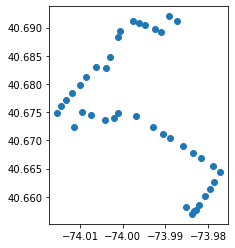

In [799]:
route_gdf.plot()